In [56]:
# Install required libraries
!pip install -U kaleido
!pip install sastrawi

In [57]:
# Libraries for Data Manipulation
import pandas as pd
import time
import json
import csv
from datetime import datetime
import numpy as np
import random
import pickle
import joblib

# Libraries for NLP Preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Libraries for modeling & evaluation
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from math import *

# Libraries for Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS

# Library for Ignore Warning Error
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
data = pd.read_csv('data.csv', encoding = 'unicode_escape')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2144 entries, 0 to 2143
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_at           2144 non-null   object
 1   id_str               2144 non-null   int64 
 2   full_text            2144 non-null   object
 3   quote_count          2144 non-null   int64 
 4   reply_count          2144 non-null   int64 
 5   retweet_count        2144 non-null   int64 
 6   favorite_count       2144 non-null   int64 
 7   lang                 2144 non-null   object
 8   user_id_str          2144 non-null   int64 
 9   conversation_id_str  2144 non-null   int64 
 10  username             2144 non-null   object
 11  tweet_url            2144 non-null   object
dtypes: int64(7), object(5)
memory usage: 201.1+ KB


In [60]:
# Check duplicate in column 'reply'
check_duplicate = data[data.duplicated('full_text')]
check_duplicate

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
234,Sat Oct 28 08:49:02 +0000 2023,1718188110478225753,ini juga berhasil membongkar kasus korupsi bes...,0,1,0,0,in,1623542459887419395,1718187486609117618,Granny_2277,https://twitter.com/Granny_2277/status/1718188...
346,Thu Oct 26 13:59:59 +0000 2023,1717541589567013072,Temen-temen yang pernah pakai maskapai garuda ...,0,6,0,0,in,1277749122296983552,1717541589567013072,UGM_FESS,https://twitter.com/UGM_FESS/status/1717541589...
503,Sat Nov 04 13:18:09 +0000 2023,1720792548518883557,Dirut Garuda Indonesia Irfan Setiaputra pastik...,0,0,1,1,in,759692754985242625,1720792548518883557,kumparan,https://twitter.com/kumparan/status/1720792548...
557,Thu Nov 02 11:52:37 +0000 2023,1720046247657246846,"Tiga maskapai BUMN, Garuda Indonesia, Citilink...",0,0,0,2,in,759692754985242625,1720046247657246846,kumparan,https://twitter.com/kumparan/status/1720046247...
605,Wed Nov 01 13:34:03 +0000 2023,1719709388934406374,@indoflyer Citilink,0,0,0,0,en,3119170825,1719709026550685918,moulanapanji,https://twitter.com/moulanapanji/status/171970...
...,...,...,...,...,...,...,...,...,...,...,...,...
2119,Wed Nov 01 06:20:04 +0000 2023,1719600173423497226,Mengenai Merger Citilink dengan Pelita Air htt...,0,0,0,0,in,23786106,1719600173423497226,kompasiana,https://twitter.com/kompasiana/status/17196001...
2120,Wed Nov 01 03:55:10 +0000 2023,1719563708131885168,Mengenai Merger Citilink dengan Pelita Air htt...,0,0,0,0,in,23786106,1719563708131885168,kompasiana,https://twitter.com/kompasiana/status/17195637...
2135,Tue Oct 31 05:38:53 +0000 2023,1719227422732947760,@GerryS Pelita Air,0,0,0,1,in,2904075276,1719195040411791393,MS_Fialmar,https://twitter.com/MS_Fialmar/status/17192274...
2139,Mon Oct 30 15:25:24 +0000 2023,1719012636153811208,"@Andriansah @GerryS Air asia, citilink, pelita...",0,0,0,1,in,60542916,1718999703990493541,janpiterjan,https://twitter.com/janpiterjan/status/1719012...


In [61]:
# Drop if there is duplicate data in the subset of "full_text" column
# After drop, dont forget to reset index
data = data.drop_duplicates(subset=['full_text'], keep='first')
data = data.reset_index(drop = True)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Sat Nov 04 22:59:40 +0000 2023,1720938895205093881,Garuda Indonesia ãå­¦å²ãããSydneyãMe...,0,0,0,2,ja,1492788391817084929,1720938895205093881,iqyomi,https://twitter.com/iqyomi/status/172093889520...
1,Sat Nov 04 14:20:26 +0000 2023,1720808223668920546,I wish Garuda Indonesia would make a playlist ...,0,0,0,0,en,116080782,1720807760940741019,wecism,https://twitter.com/wecism/status/172080822366...
2,Sat Nov 04 13:18:09 +0000 2023,1720792548518883557,Dirut Garuda Indonesia Irfan Setiaputra pastik...,0,0,1,1,in,759692754985242625,1720792548518883557,kumparan,https://twitter.com/kumparan/status/1720792548...
3,Sat Nov 04 12:39:05 +0000 2023,1720782718437568919,Pesawat Garuda Indonesia tujuan Ambon-Jakarta ...,0,0,0,0,in,759692754985242625,1720782718437568919,kumparan,https://twitter.com/kumparan/status/1720782718...
4,Sat Nov 04 12:05:49 +0000 2023,1720774348410417418,My very first capture at YIA...ðð . Arr...,0,0,2,5,en,1247583472740233216,1720774348410417418,stamaviation,https://twitter.com/stamaviation/status/172077...
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,Tue Oct 31 04:24:56 +0000 2023,1719208810034991396,@GerryS Pelita air,0,0,0,1,in,294955197,1719195040411791393,Aris_Munandar90,https://twitter.com/Aris_Munandar90/status/171...
2044,Tue Oct 31 00:41:51 +0000 2023,1719152670408319143,"Mencoba maskapai ke 3 BUMN, Pelita Air. https:...",0,0,0,1,in,1547059411881177089,1719152670408319143,joshuarihi05,https://twitter.com/joshuarihi05/status/171915...
2045,Mon Oct 30 08:50:00 +0000 2023,1718913127931077010,Pelita Air Kembali Perkuat Armadanya dengan Ai...,0,0,0,0,in,1504683416314585090,1718913127931077010,disway_id,https://twitter.com/disway_id/status/171891312...
2046,Mon Oct 30 06:00:09 +0000 2023,1718870383905096054,Flight CGK - YIA @hello_pelitaair https://t.co...,0,0,0,1,in,535172539,1718870383905096054,muslimsyaebani,https://twitter.com/muslimsyaebani/status/1718...


In [62]:
# Process Cleaning
def cleaningText(tweets):
    # Convert text to lowercase
    tweets = tweets.lower()
    # Remove non-ascii characters from the string
    tweets = re.sub(r'[^\x00-\x7f]',r'', tweets)
    # Replace 2+ dots with space
    tweets = re.sub(r'\.{2,}', ' ', tweets)
    # Remove @username
    tweets = re.sub(r"(?:\@|https?\://)\S+", "", tweets)
    # Remove old style retweet text "RT"
    tweets = re.sub(r'RT', '', tweets)
    # Remove newline
    tweets = tweets.replace('\n','')
    # Remove hashtags
    tweets = re.sub(r'#\S+', ' ', tweets)
    # Remove single character
    pattern = r"((?<=^)|(?<= )).((?=$)|(?= ))"
    tweets = re.sub("\s+", " ", re.sub(pattern, '', tweets))
    # Remove number
    tweets = re.sub(r"[^a-zA-Z^']", " ", tweets)
    # Remove url
    tweets = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", tweets)
    tweets = re.sub(r"http\S+", "", tweets)
    # Strip space, " and ' from tweet
    tweets = tweets.strip(' "\'')
    # Replace multiple spaces with a single space
    tweets = re.sub(r'\s+', ' ', tweets)
    # Remove punctuation
    tweets = tweets.translate(str.maketrans("","",string.punctuation))
    return tweets

data['full_text'] = data['full_text'].apply(cleaningText)

print('Cleaning Text Result : \n')
print(data['full_text'].head(50))

Cleaning Text Result : 

0     garuda indonesia sydneymelbourneperth sales of...
1     wish garuda indonesia would make playlist on s...
2     dirut garuda indonesia irfan setiaputra pastik...
3     pesawat garuda indonesia tujuan ambon jakarta ...
4     my very first capture at yia arrived at friday...
5     penumpang pesawat garuda indonesia rute ambon ...
6     pesawat garuda indonesia tujuan ambon jakarta ...
7     pesawat garuda indonesia tujuan ambon jakarta ...
8     presiden indonesia joko widodo meresmikan peng...
9     kemaskini presiden indonesia joko widodo meras...
10       centang biru modal bulanan aja bangga cuakkzzz
11    nikmati potongan hingga rp dengan kemudahan ci...
12    dapatkan potongan rp untuk pemegang kartu debi...
13               sportify lol kasus garuda indonesia ya
14             miss pramugari garuda indonesia pict vid
15    triple vs mini catering vs garuda indonesia ga...
16                             r gaa a garuda indonesia
17                not t

In [63]:
# Process Remove symbol
def remove_symbol(tweets):
    tweets = ''.join(re.sub(r"[\!\@\#$\%\^\&\*\?\,\"\|\:]+", "", tweets))
    return tweets

data['full_text'] = data['full_text'].apply(remove_symbol)
print('Remove Symbol Result : \n')
print(data['full_text'].head(50))

Remove Symbol Result : 

0     garuda indonesia sydneymelbourneperth sales of...
1     wish garuda indonesia would make playlist on s...
2     dirut garuda indonesia irfan setiaputra pastik...
3     pesawat garuda indonesia tujuan ambon jakarta ...
4     my very first capture at yia arrived at friday...
5     penumpang pesawat garuda indonesia rute ambon ...
6     pesawat garuda indonesia tujuan ambon jakarta ...
7     pesawat garuda indonesia tujuan ambon jakarta ...
8     presiden indonesia joko widodo meresmikan peng...
9     kemaskini presiden indonesia joko widodo meras...
10       centang biru modal bulanan aja bangga cuakkzzz
11    nikmati potongan hingga rp dengan kemudahan ci...
12    dapatkan potongan rp untuk pemegang kartu debi...
13               sportify lol kasus garuda indonesia ya
14             miss pramugari garuda indonesia pict vid
15    triple vs mini catering vs garuda indonesia ga...
16                             r gaa a garuda indonesia
17                not t

In [64]:
# Process Tokenizing
def tokenizingText(tweets):
    return word_tokenize(tweets)

data['full_text'] = data['full_text'].apply(tokenizingText)
print('Tokenizing Result : \n')
print(data['full_text'].head(50))

Tokenizing Result : 

0     [garuda, indonesia, sydneymelbourneperth, sale...
1     [wish, garuda, indonesia, would, make, playlis...
2     [dirut, garuda, indonesia, irfan, setiaputra, ...
3     [pesawat, garuda, indonesia, tujuan, ambon, ja...
4     [my, very, first, capture, at, yia, arrived, a...
5     [penumpang, pesawat, garuda, indonesia, rute, ...
6     [pesawat, garuda, indonesia, tujuan, ambon, ja...
7     [pesawat, garuda, indonesia, tujuan, ambon, ja...
8     [presiden, indonesia, joko, widodo, meresmikan...
9     [kemaskini, presiden, indonesia, joko, widodo,...
10    [centang, biru, modal, bulanan, aja, bangga, c...
11    [nikmati, potongan, hingga, rp, dengan, kemuda...
12    [dapatkan, potongan, rp, untuk, pemegang, kart...
13        [sportify, lol, kasus, garuda, indonesia, ya]
14      [miss, pramugari, garuda, indonesia, pict, vid]
15    [triple, vs, mini, catering, vs, garuda, indon...
16                       [r, gaa, a, garuda, indonesia]
17         [not, the, vira

In [65]:
# Process Stemming
def stemmingText(tweets):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in tweets]
    return tweets

data['full_text'] = data['full_text'].apply(stemmingText)
print('Stemming Result : \n')
print(data['full_text'].head(50))

Stemming Result : 

0     [garuda, indonesia, sydneymelbourneperth, sale...
1     [wish, garuda, indonesia, would, make, playlis...
2     [dirut, garuda, indonesia, irfan, setiaputra, ...
3     [pesawat, garuda, indonesia, tujuan, ambon, ja...
4     [my, very, first, capture, at, yia, arrived, a...
5     [penumpang, pesawat, garuda, indonesia, rute, ...
6     [pesawat, garuda, indonesia, tujuan, ambon, ja...
7     [pesawat, garuda, indonesia, tujuan, ambon, ja...
8     [presiden, indonesia, joko, widodo, meresmikan...
9     [kemaskini, presiden, indonesia, joko, widodo,...
10    [centang, biru, modal, bulanan, aja, bangga, c...
11    [nikmati, potongan, hingga, rp, dengan, kemuda...
12    [dapatkan, potongan, rp, untuk, pemegang, kart...
13        [sportify, lol, kasus, garuda, indonesia, ya]
14      [miss, pramugari, garuda, indonesia, pict, vid]
15    [triple, vs, mini, catering, vs, garuda, indon...
16                       [r, gaa, a, garuda, indonesia]
17         [not, the, viral,

In [66]:
# Process Stopwords
def filteringText(tweets):
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for twt in tweets:
        if twt not in listStopwords:
            filtered.append(twt)
    tweets = filtered
    return tweets

data['full_text'] = data['full_text'].apply(filteringText)
print('Stopwords Result : \n')
print(data['full_text'].head(50))

Stopwords Result : 

0     [garuda, indonesia, sydneymelbourneperth, sale...
1     [wish, garuda, indonesia, would, make, playlis...
2     [dirut, garuda, indonesia, irfan, setiaputra, ...
3     [pesawat, garuda, indonesia, tujuan, ambon, ja...
4     [my, very, first, capture, at, yia, arrived, a...
5     [penumpang, pesawat, garuda, indonesia, rute, ...
6     [pesawat, garuda, indonesia, tujuan, ambon, ja...
7     [pesawat, garuda, indonesia, tujuan, ambon, ja...
8     [presiden, indonesia, joko, widodo, meresmikan...
9     [kemaskini, presiden, indonesia, joko, widodo,...
10    [centang, biru, modal, bulanan, aja, bangga, c...
11    [nikmati, potongan, rp, kemudahan, cicilan, tm...
12    [dapatkan, potongan, rp, pemegang, kartu, debi...
13               [sportify, lol, garuda, indonesia, ya]
14      [miss, pramugari, garuda, indonesia, pict, vid]
15    [triple, vs, mini, catering, vs, garuda, indon...
16                       [r, gaa, a, garuda, indonesia]
17         [not, the, viral

In [67]:
# Return the data back to its original form which is not a token
def join_text_list(Text):
    return ' '.join(Text)

data['reply_token'] = data['full_text']

data['full_text'] = data['full_text'].apply(join_text_list)
print(data['full_text'].head(50))

0     garuda indonesia sydneymelbourneperth sales of...
1     wish garuda indonesia would make playlist on s...
2     dirut garuda indonesia irfan setiaputra pastik...
3     pesawat garuda indonesia tujuan ambon jakarta ...
4     my very first capture at yia arrived at friday...
5     penumpang pesawat garuda indonesia rute ambon ...
6     pesawat garuda indonesia tujuan ambon jakarta ...
7     pesawat garuda indonesia tujuan ambon jakarta ...
8     presiden indonesia joko widodo meresmikan peng...
9     kemaskini presiden indonesia joko widodo meras...
10       centang biru modal bulanan aja bangga cuakkzzz
11    nikmati potongan rp kemudahan cicilan tmrw pay...
12    dapatkan potongan rp pemegang kartu debit btn ...
13                     sportify lol garuda indonesia ya
14             miss pramugari garuda indonesia pict vid
15    triple vs mini catering vs garuda indonesia ga...
16                             r gaa a garuda indonesia
17                not the viral gundik garuda in

In [68]:
# Remove data that have NAN value in column full_text
data.dropna(subset=['full_text'], inplace = True)
# To reset the index when data with NAN values ​​are removed so that the index numbering matches
data = data.reset_index(drop = True)
# Print the results of the dataframe that has been created
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,reply_token
0,Sat Nov 04 22:59:40 +0000 2023,1720938895205093881,garuda indonesia sydneymelbourneperth sales of...,0,0,0,2,ja,1492788391817084929,1720938895205093881,iqyomi,https://twitter.com/iqyomi/status/172093889520...,"[garuda, indonesia, sydneymelbourneperth, sale..."
1,Sat Nov 04 14:20:26 +0000 2023,1720808223668920546,wish garuda indonesia would make playlist on s...,0,0,0,0,en,116080782,1720807760940741019,wecism,https://twitter.com/wecism/status/172080822366...,"[wish, garuda, indonesia, would, make, playlis..."
2,Sat Nov 04 13:18:09 +0000 2023,1720792548518883557,dirut garuda indonesia irfan setiaputra pastik...,0,0,1,1,in,759692754985242625,1720792548518883557,kumparan,https://twitter.com/kumparan/status/1720792548...,"[dirut, garuda, indonesia, irfan, setiaputra, ..."
3,Sat Nov 04 12:39:05 +0000 2023,1720782718437568919,pesawat garuda indonesia tujuan ambon jakarta ...,0,0,0,0,in,759692754985242625,1720782718437568919,kumparan,https://twitter.com/kumparan/status/1720782718...,"[pesawat, garuda, indonesia, tujuan, ambon, ja..."
4,Sat Nov 04 12:05:49 +0000 2023,1720774348410417418,my very first capture at yia arrived at friday...,0,0,2,5,en,1247583472740233216,1720774348410417418,stamaviation,https://twitter.com/stamaviation/status/172077...,"[my, very, first, capture, at, yia, arrived, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,Tue Oct 31 04:24:56 +0000 2023,1719208810034991396,pelita air,0,0,0,1,in,294955197,1719195040411791393,Aris_Munandar90,https://twitter.com/Aris_Munandar90/status/171...,"[pelita, air]"
2044,Tue Oct 31 00:41:51 +0000 2023,1719152670408319143,mencoba maskapai bumn pelita air,0,0,0,1,in,1547059411881177089,1719152670408319143,joshuarihi05,https://twitter.com/joshuarihi05/status/171915...,"[mencoba, maskapai, bumn, pelita, air]"
2045,Mon Oct 30 08:50:00 +0000 2023,1718913127931077010,pelita air perkuat armadanya airbus a unit men...,0,0,0,0,in,1504683416314585090,1718913127931077010,disway_id,https://twitter.com/disway_id/status/171891312...,"[pelita, air, perkuat, armadanya, airbus, a, u..."
2046,Mon Oct 30 06:00:09 +0000 2023,1718870383905096054,flight cgk yia,0,0,0,1,in,535172539,1718870383905096054,muslimsyaebani,https://twitter.com/muslimsyaebani/status/1718...,"[flight, cgk, yia]"


In [69]:
data = data.rename(columns={'reply_token': 'token'})

In [70]:
data.head(30)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,token
0,Sat Nov 04 22:59:40 +0000 2023,1720938895205093881,garuda indonesia sydneymelbourneperth sales of...,0,0,0,2,ja,1492788391817084929,1720938895205093881,iqyomi,https://twitter.com/iqyomi/status/172093889520...,"[garuda, indonesia, sydneymelbourneperth, sale..."
1,Sat Nov 04 14:20:26 +0000 2023,1720808223668920546,wish garuda indonesia would make playlist on s...,0,0,0,0,en,116080782,1720807760940741019,wecism,https://twitter.com/wecism/status/172080822366...,"[wish, garuda, indonesia, would, make, playlis..."
2,Sat Nov 04 13:18:09 +0000 2023,1720792548518883557,dirut garuda indonesia irfan setiaputra pastik...,0,0,1,1,in,759692754985242625,1720792548518883557,kumparan,https://twitter.com/kumparan/status/1720792548...,"[dirut, garuda, indonesia, irfan, setiaputra, ..."
3,Sat Nov 04 12:39:05 +0000 2023,1720782718437568919,pesawat garuda indonesia tujuan ambon jakarta ...,0,0,0,0,in,759692754985242625,1720782718437568919,kumparan,https://twitter.com/kumparan/status/1720782718...,"[pesawat, garuda, indonesia, tujuan, ambon, ja..."
4,Sat Nov 04 12:05:49 +0000 2023,1720774348410417418,my very first capture at yia arrived at friday...,0,0,2,5,en,1247583472740233216,1720774348410417418,stamaviation,https://twitter.com/stamaviation/status/172077...,"[my, very, first, capture, at, yia, arrived, a..."
5,Sat Nov 04 12:02:37 +0000 2023,1720773543812796533,penumpang pesawat garuda indonesia rute ambon ...,0,0,0,1,in,759692754985242625,1720773543812796533,kumparan,https://twitter.com/kumparan/status/1720773543...,"[penumpang, pesawat, garuda, indonesia, rute, ..."
6,Sat Nov 04 11:53:05 +0000 2023,1720771143970459795,pesawat garuda indonesia tujuan ambon jakarta ...,0,0,0,2,in,759692754985242625,1720771143970459795,kumparan,https://twitter.com/kumparan/status/1720771143...,"[pesawat, garuda, indonesia, tujuan, ambon, ja..."
7,Sat Nov 04 11:09:33 +0000 2023,1720760189383807193,pesawat garuda indonesia tujuan ambon jakarta ...,0,0,0,0,in,759692754985242625,1720760189383807193,kumparan,https://twitter.com/kumparan/status/1720760189...,"[pesawat, garuda, indonesia, tujuan, ambon, ja..."
8,Sat Nov 04 10:32:59 +0000 2023,1720750983217864979,presiden indonesia joko widodo meresmikan peng...,0,0,0,7,in,1695571783418777600,1720598149902029199,RidwanRidw65219,https://twitter.com/RidwanRidw65219/status/172...,"[presiden, indonesia, joko, widodo, meresmikan..."
9,Sat Nov 04 10:14:16 +0000 2023,1720746273404567746,kemaskini presiden indonesia joko widodo meras...,32,46,3286,6054,in,2194068895,1720746273404567746,Marchfoward,https://twitter.com/Marchfoward/status/1720746...,"[kemaskini, presiden, indonesia, joko, widodo,..."


In [71]:
file_path = 'databersih.csv'
data.to_csv(file_path, index=False)

In [72]:
import csv

def load_lexicon(file_path):
    lexicon = dict()
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header or invalid rows
            if i == 0 or len(row) != 2:
                continue
            try:
                lexicon[row[0]] = int(row[1])
            except ValueError:
                print(f"Warning: Invalid weight for word '{row[0]}'. Skipping this entry.")
    return lexicon

# Load lexicon positive and negative data
lexicon_positive = load_lexicon('positive.csv')
lexicon_negative = load_lexicon('negative.csv')

# Function to determine sentiment polarity of comment
def lexicon_labeling_text(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    polarity = 'positif' if score > 0 else ('negatif' if score < 0 else 'netral')
    return score, polarity


In [73]:
# Results from determine sentiment label of tweets
labeling = data['token'].apply(lexicon_labeling_text)
labeling = list(zip(*labeling))
data['label_score'] = labeling[0]
data['label'] = labeling[1]
print(data['label'].value_counts())

negatif    896
positif    764
netral     388
Name: label, dtype: int64


In [74]:
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,token,label_score,label
0,Sat Nov 04 22:59:40 +0000 2023,1720938895205093881,garuda indonesia sydneymelbourneperth sales of...,0,0,0,2,ja,1492788391817084929,1720938895205093881,iqyomi,https://twitter.com/iqyomi/status/172093889520...,"[garuda, indonesia, sydneymelbourneperth, sale...",0,netral
1,Sat Nov 04 14:20:26 +0000 2023,1720808223668920546,wish garuda indonesia would make playlist on s...,0,0,0,0,en,116080782,1720807760940741019,wecism,https://twitter.com/wecism/status/172080822366...,"[wish, garuda, indonesia, would, make, playlis...",0,netral
2,Sat Nov 04 13:18:09 +0000 2023,1720792548518883557,dirut garuda indonesia irfan setiaputra pastik...,0,0,1,1,in,759692754985242625,1720792548518883557,kumparan,https://twitter.com/kumparan/status/1720792548...,"[dirut, garuda, indonesia, irfan, setiaputra, ...",7,positif
3,Sat Nov 04 12:39:05 +0000 2023,1720782718437568919,pesawat garuda indonesia tujuan ambon jakarta ...,0,0,0,0,in,759692754985242625,1720782718437568919,kumparan,https://twitter.com/kumparan/status/1720782718...,"[pesawat, garuda, indonesia, tujuan, ambon, ja...",-12,negatif
4,Sat Nov 04 12:05:49 +0000 2023,1720774348410417418,my very first capture at yia arrived at friday...,0,0,2,5,en,1247583472740233216,1720774348410417418,stamaviation,https://twitter.com/stamaviation/status/172077...,"[my, very, first, capture, at, yia, arrived, a...",0,netral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,Tue Oct 31 04:24:56 +0000 2023,1719208810034991396,pelita air,0,0,0,1,in,294955197,1719195040411791393,Aris_Munandar90,https://twitter.com/Aris_Munandar90/status/171...,"[pelita, air]",1,positif
2044,Tue Oct 31 00:41:51 +0000 2023,1719152670408319143,mencoba maskapai bumn pelita air,0,0,0,1,in,1547059411881177089,1719152670408319143,joshuarihi05,https://twitter.com/joshuarihi05/status/171915...,"[mencoba, maskapai, bumn, pelita, air]",4,positif
2045,Mon Oct 30 08:50:00 +0000 2023,1718913127931077010,pelita air perkuat armadanya airbus a unit men...,0,0,0,0,in,1504683416314585090,1718913127931077010,disway_id,https://twitter.com/disway_id/status/171891312...,"[pelita, air, perkuat, armadanya, airbus, a, u...",-3,negatif
2046,Mon Oct 30 06:00:09 +0000 2023,1718870383905096054,flight cgk yia,0,0,0,1,in,535172539,1718870383905096054,muslimsyaebani,https://twitter.com/muslimsyaebani/status/1718...,"[flight, cgk, yia]",0,netral


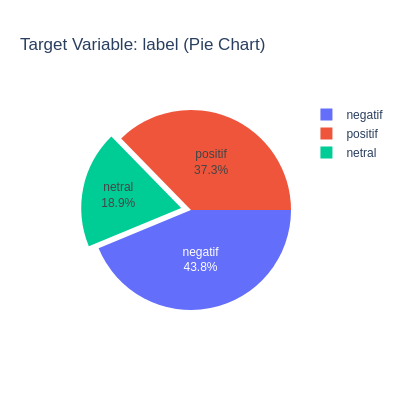

In [75]:
# View the amount of data for each label on the dataset
fig = px.pie(data, names = 'label', width=400, height=400, title = 'Target Variable: label (Pie Chart)')
fig.update_traces(rotation=90, pull = [0.1], textinfo = "percent+label")
fig.show('png')

In [76]:
print(data['label'].unique())


['netral' 'positif' 'negatif']


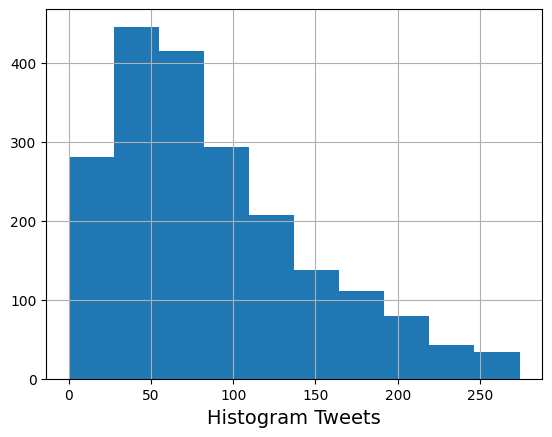

In [77]:
# View distribution histogram of tweets
ax = data['full_text'].str.len().hist()
plt.xlabel('Histogram Tweets', fontsize=14)
plt.show()

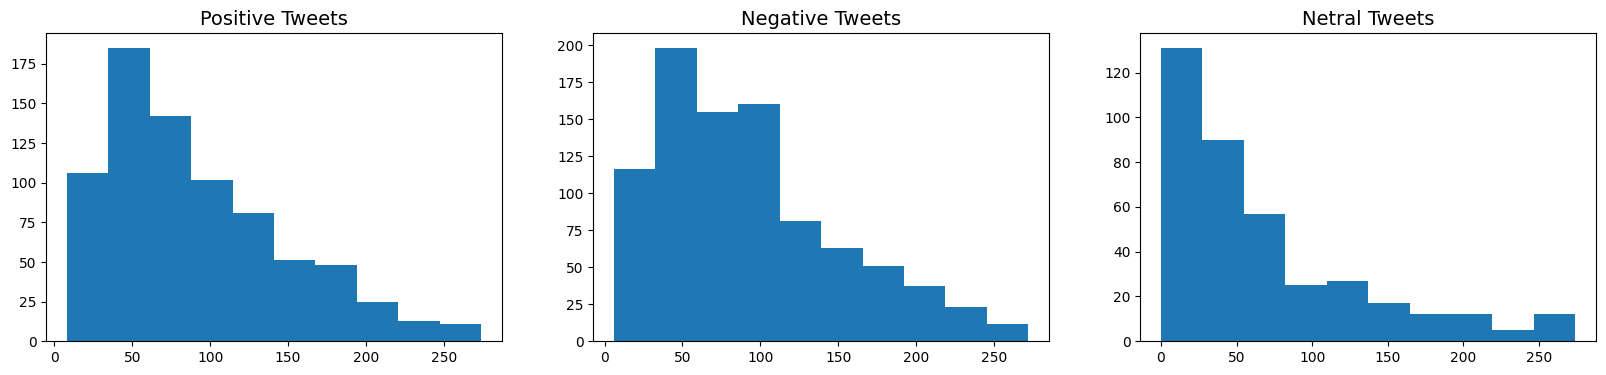

In [78]:
# View distribution histogram tweets of each label
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.hist(data[data['label']=='positif']['full_text'].str.len())
ax1.set_title('Positive Tweets', fontsize=14)
ax2.hist(data[data['label']=='negatif']['full_text'].str.len())
ax2.set_title('Negative Tweets', fontsize=14)
ax3.hist(data[data['label']=='netral']['full_text'].str.len())
ax3.set_title('Netral Tweets', fontsize=14)
plt.show()

In [79]:
data = data.rename(columns={'id_str': 'tweet_id'})

In [80]:
# 1295 -> amount of dataset final
idx = np.random.randint(0,1295 ,1295)
reduce_data = data.loc[idx]

# Splitting dataset into training and testing
# Data training => data that use for training phase
# Data testing => data that use for testing phase
train_dataset, test_dataset = train_test_split(reduce_data, test_size = 0.3, random_state = 101)
# Menetapkan isi dari variabel train yang termasuk isi dari data training dalam bentuk list
train_data = train_dataset[['created_at', 'tweet_id', 'full_text', 'retweet_count', 'label']].reset_index().drop('index', axis=1)
# Menetapkan isi dari variabel test yang termasuk isi dari data testing dalam bentuk list
test_data = test_dataset[['created_at', 'tweet_id', 'full_text', 'retweet_count', 'label']].reset_index().drop('index', axis=1)

In [81]:
# Define dependent and independent variabel
y_test = test_data.label
X_test = test_data.full_text
y_train = train_data.label
X_train = train_data.full_text

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(906,) (906,)
(389,) (389,)


In [82]:
# Feature extraction
vect = TfidfVectorizer(use_idf=True, max_df=0.8, min_df=2)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

# Standardization
X_train = normalize(X_train)
X_test = normalize(X_test)

print(X_train.shape)
print(X_test.shape)

(906, 1643)
(389, 1643)


In [83]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
import time

# Define model
NaiveBayes = GaussianNB()

# Parameter grid for tuning
nb_param_grid = {"var_smoothing": [1.e-8, 1.e-9, 1.e-10]}

# 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV
tuning_naive_bayes = GridSearchCV(NaiveBayes, nb_param_grid, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)

# Fitting model
start = time.time()
sample = class_weight.compute_sample_weight('balanced', y_train)
tuning_naive_bayes = tuning_naive_bayes.fit(np.asarray(X_train.todense()), y_train, sample_weight=sample)
stop = time.time()

print(f"Training time: {stop - start}s")
print('Train Accuracy : %.3f' % tuning_naive_bayes.best_estimator_.score(np.asarray(X_train.todense()), y_train))
print('Best Parameters : ', tuning_naive_bayes.best_params_)
print('\n')

# Gridsearch summary
means = tuning_naive_bayes.cv_results_['mean_test_score']
stds = tuning_naive_bayes.cv_results_['std_test_score']
params = tuning_naive_bayes.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


Training time: 3.7630884647369385s
Train Accuracy : 0.908
Best Parameters :  {'var_smoothing': 1e-08}


Mean: 0.743919 Stdev:(0.037609) with: {'var_smoothing': 1e-08}
Mean: 0.742821 Stdev:(0.037009) with: {'var_smoothing': 1e-09}
Mean: 0.742821 Stdev:(0.037009) with: {'var_smoothing': 1e-10}


Testing time: 0.014081716537475586s
Tuning Hyperparameter Naive Bayes accuracy is 74.04%
------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

     negatif     0.9231    0.6275    0.7471       153
      netral     0.5895    0.7179    0.6474        78
     positif     0.7158    0.8608    0.7816       158

    accuracy                         0.7404       389
   macro avg     0.7428    0.7354    0.7254       389
weighted avg     0.7720    0.7404    0.7411       389

------------------------------------------------


Confusion Matrix:


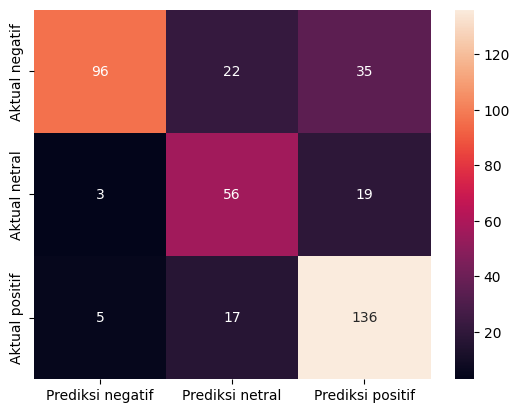

In [84]:
start = time.time()
# Predict model (do testing using data testing)
predicted_tuning_naive_bayes = tuning_naive_bayes.best_estimator_.predict(np.asarray(X_test.todense()))
stop = time.time()
print(f"Testing time: {stop - start}s")

# Get accuracy score of predicted model
accuracy_score_nb_tuning = metrics.accuracy_score(predicted_tuning_naive_bayes, y_test)

# Evaluation model
print('Tuning Hyperparameter Naive Bayes accuracy is', str('{:04.2f}'.format(accuracy_score_nb_tuning * 100)) + '%')
print('------------------------------------------------')
print('\n')
print('Classification Report:')
target_names = ['negatif', 'netral', 'positif']
print(classification_report(y_test, predicted_tuning_naive_bayes, target_names=target_names, digits=4))
print('------------------------------------------------')
print('\n')
print('Confusion Matrix:')
cm = pd.DataFrame(confusion_matrix(y_test, predicted_tuning_naive_bayes),
                  index=["Aktual negatif", "Aktual netral", "Aktual positif"],
                  columns=["Prediksi negatif", "Prediksi netral", "Prediksi positif"])
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [85]:
# Save the vectorizer
vec_file = 'vectorizer.pkl'
pickle.dump(vect, open(vec_file, 'wb'))

# Save model for prediction new data
pickle.dump(tuning_naive_bayes,open("Tuning-Model-NB.pkl","wb"))

In [86]:
test_data["Prediction"] = predicted_tuning_naive_bayes
test_data

,created_at,tweet_id,full_text,retweet_count,label,Prediction
0,Tue Oct 17 02:03:18 +0000 2023,1714099736624709896,qg lageh citilink pk gqh airbus a cgk yia,0,netral,netral
1,Fri Oct 27 14:45:33 +0000 2023,1717915442810081656,keren bongkar korupsi asabri jiwasraya garuda ...,30,negatif,negatif
2,Mon Oct 30 04:00:01 +0000 2023,1718840150623498426,jelajahi destinasi menarik garuda indonesia da...,1,netral,negatif
3,Sat Oct 21 10:06:29 +0000 2023,1715670887771562013,kembalikan kanda pemerintahan kapabilitas paha...,0,positif,netral
4,Sat Oct 28 09:24:36 +0000 2023,1718197061383021020,rute bali rute bali balikpapan rute batam pale...,11,netral,positif
...,...,...,...,...,...,...
384,Sat Oct 28 20:49:30 +0000 2023,1718369419456557343,rang orang ninggalin unlvr beralih lion wings ...,0,negatif,negatif
385,Wed Oct 18 01:23:51 +0000 2023,1714452197843550495,kemarin superairjet citilink pindah kertajati ...,25,netral,netral
386,Wed Oct 25 14:24:23 +0000 2023,1717185341399159057,pertamina telkom kai garuda indonesia bgtt,0,netral,positif
387,Tue Oct 31 22:33:28 +0000 2023,1719482749877203005,dont forget to sue bunch of vloggers after the...,0,netral,netral


In [87]:
test_negatif = test_data[test_data['Prediction'] == 'negatif']
test_negatif

,created_at,tweet_id,full_text,retweet_count,label,Prediction
1,Fri Oct 27 14:45:33 +0000 2023,1717915442810081656,keren bongkar korupsi asabri jiwasraya garuda ...,30,negatif,negatif
2,Mon Oct 30 04:00:01 +0000 2023,1718840150623498426,jelajahi destinasi menarik garuda indonesia da...,1,netral,negatif
5,Tue Oct 24 06:25:56 +0000 2023,1716702545345945822,discover the seamless journey from karachi to ...,0,negatif,negatif
11,Wed Oct 25 06:54:27 +0000 2023,1717072109414007170,pt garuda indonesia persero tbk pembukaan rute...,3,negatif,negatif
18,Fri Oct 27 09:36:48 +0000 2023,1717837742501953914,emirates and batik air strengthen ties offerin...,0,negatif,negatif
...,...,...,...,...,...,...
371,Sun Oct 29 01:00:00 +0000 2023,1718432461468893628,pt pertamina persero garuda indonesia berhasil...,0,negatif,negatif
376,Tue Oct 17 01:18:49 +0000 2023,1714088544833294793,selamat pagiii selasa sidoarjo putri marino sa...,4,positif,negatif
377,Tue Oct 24 16:30:02 +0000 2023,1716854571384119538,one stop shopping garuda indonesia travel fair...,0,positif,negatif
379,Thu Oct 26 11:47:20 +0000 2023,1717508206317158767,negara ternama peserta piala dunia u memilih t...,0,negatif,negatif


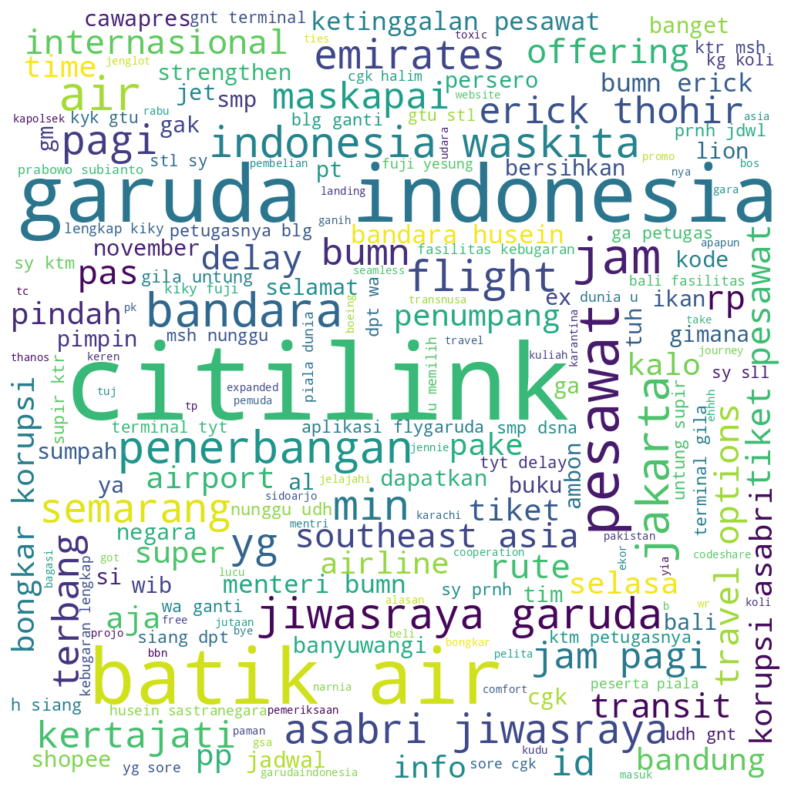

In [88]:
words = ' '.join(test_negatif["full_text"])

wordcloud = WordCloud(width=1000, height=1000, mode='RGBA', background_color='white').generate(words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
wordcloud.to_file('Negatif.png')
plt.show()

In [89]:
test_positif = test_data[test_data['Prediction'] == 'positif']
test_positif

,created_at,tweet_id,full_text,retweet_count,label,Prediction
4,Sat Oct 28 09:24:36 +0000 2023,1718197061383021020,rute bali rute bali balikpapan rute batam pale...,11,netral,positif
6,Sat Oct 28 22:04:56 +0000 2023,1718388406143914272,aman mbeb udah booking superjet citilink,0,positif,positif
7,Wed Oct 25 13:05:43 +0000 2023,1717165544997290260,tinggal doa latihan semangat garuda indonesia ...,0,positif,positif
8,Thu Nov 02 20:30:00 +0000 2023,1720176452816326811,worlds star airlines all nippon airways asiana...,2,negatif,positif
14,Fri Oct 20 00:48:38 +0000 2023,1715168111719014618,but didnt enjoy the flight pelayanannya gue ku...,0,positif,positif
...,...,...,...,...,...,...
374,Tue Oct 24 05:41:05 +0000 2023,1716691261124673592,obrolan nyaman aman mohon cek dm ya kak mr,0,netral,positif
378,Thu Nov 02 02:52:12 +0000 2023,1719910249497587854,halo kak perihal aktual jadwal penerbangan sar...,0,positif,positif
382,Tue Oct 17 15:40:46 +0000 2023,1714305460764102873,jujur ya garuda gue landingnya ga soft dr yg e...,0,positif,positif
386,Wed Oct 25 14:24:23 +0000 2023,1717185341399159057,pertamina telkom kai garuda indonesia bgtt,0,netral,positif


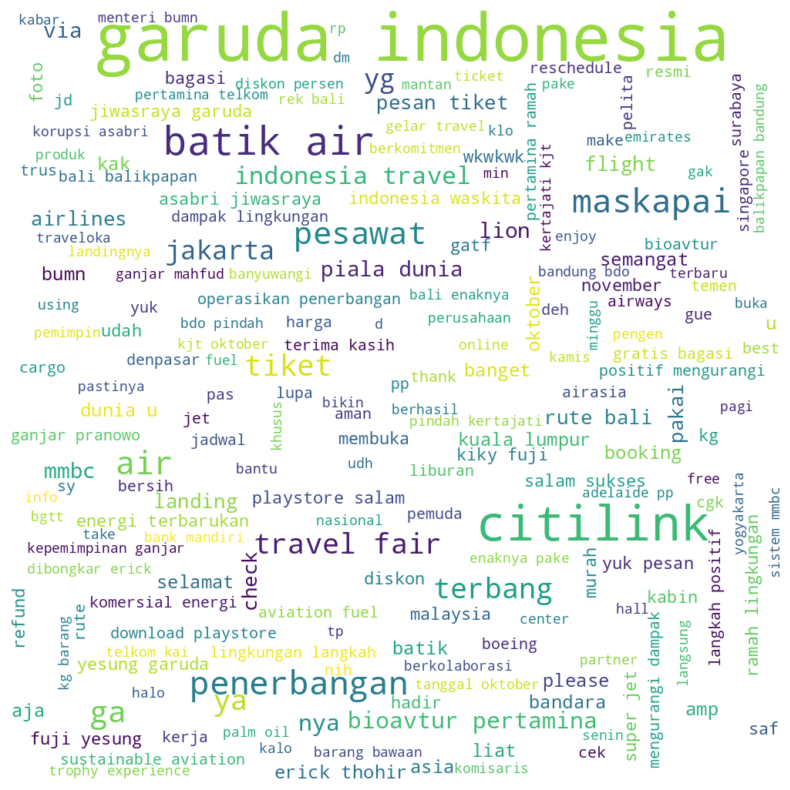

In [90]:
words = ' '.join(test_positif["full_text"])

wordcloud = WordCloud(width=1000, height=1000, mode='RGBA', background_color='white').generate(words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
wordcloud.to_file('Positif.png')
plt.show()

In [91]:
test_netral = test_data[test_data['Prediction'] == 'netral']
test_netral

,created_at,tweet_id,full_text,retweet_count,label,Prediction
0,Tue Oct 17 02:03:18 +0000 2023,1714099736624709896,qg lageh citilink pk gqh airbus a cgk yia,0,netral,netral
3,Sat Oct 21 10:06:29 +0000 2023,1715670887771562013,kembalikan kanda pemerintahan kapabilitas paha...,0,positif,netral
9,Fri Oct 20 06:26:50 +0000 2023,1715253221458067718,iya nder kaya pesawat citilink ya pesawatnya g...,0,negatif,netral
10,Wed Oct 25 19:18:06 +0000 2023,1717259255370469749,gue nemu batik air malaysia yg harganya oke in...,0,netral,netral
12,Mon Oct 30 10:25:05 +0000 2023,1718937059640143872,yg ngerasain citilink sebelah beli pop mie kua...,0,negatif,netral
...,...,...,...,...,...,...
380,Wed Oct 25 15:27:34 +0000 2023,1717201240499855390,liverpool indonesia pesawat garuda indonesia k...,0,negatif,netral
381,Wed Nov 01 10:46:46 +0000 2023,1719667289845330200,flying with batik air,0,negatif,netral
383,Sat Oct 28 03:35:16 +0000 2023,1718109146900554144,susahnya mengontak lion air group serasa zaman...,0,negatif,netral
385,Wed Oct 18 01:23:51 +0000 2023,1714452197843550495,kemarin superairjet citilink pindah kertajati ...,25,netral,netral


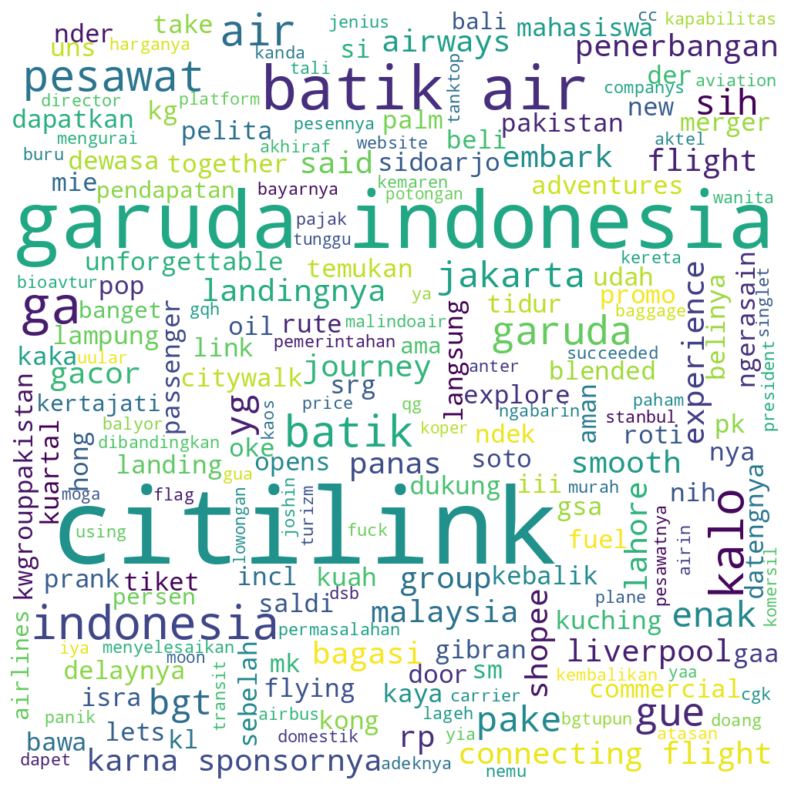

In [92]:
words = ' '.join(test_netral["full_text"])

wordcloud = WordCloud(width=1000, height=1000, mode='RGBA', background_color='white').generate(words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
wordcloud.to_file('Netral.png')
plt.show()

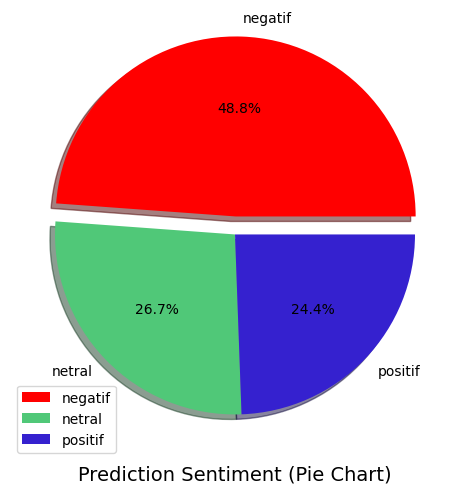

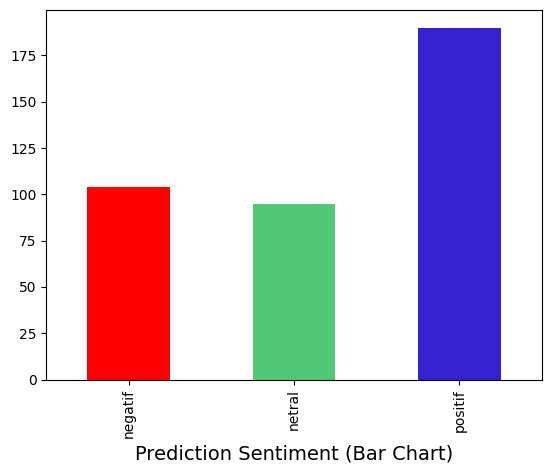

In [93]:
# Data to plot
labels = ['negatif', 'netral', 'positif']
colors = ('#FF0000', '#50C878', '#3521cf')
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
fig, ax = plt.subplots()
ax.pie(test_data.Prediction.value_counts(), labels=labels, autopct='%.1f%%', explode=explode, shadow=True, colors=colors)
ax.legend(labels, loc='best')
ax.set_aspect('equal')
plt.tight_layout()
plt.xlabel('Prediction Sentiment (Pie Chart)', fontsize=14)
plt.show()

# Menampilkan grafik review berdasarkan sentiment dalam bentuk grafik bar
test_data['Prediction'].value_counts(dropna=False).sort_index().plot(kind='bar', color=['#FF0000', '#50C878', '#3521cf'])
plt.xlabel('Prediction Sentiment (Bar Chart)', fontsize=14)
plt.show()

In [94]:
def text_preprocessing(text):
    text = remove_text_special(text)
    text = remove_emoji(text)
    # Tokenizing
    tokens = word_tokenize(text)
    # Removing stop words
    stopwords = stopword_removal(tokens)
    # Create Stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in stopwords]
    return " ".join(stemmed_tokens).strip().lower()

# Remove special text
def remove_text_special(text):
    # Remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '',str(text))
    # Replace kata yang berulang-ulang ('oooooo' menjadi '00')
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Remove @username
    text = re.sub('@[^\s]+','',text)
    # Remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # Remove angka
    text = re.sub('[0-9]+', '', text)
    # Remove url
    text = re.sub(r"http\S+", "", text)
    # Remove hashtags
    text = re.sub(r'#', '', text)
    # Strip space, " and ' from tweet
    text = text.strip(' "\'')
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans("","",string.punctuation))
    # Remove character
    text = text.replace("\n",' ').replace("Diterjemahkan oleh Google",' ').replace("Asli",' ')
    # Remove url uncomplete
    return text.replace("http://", " ").replace("https://", " ")

# Remove emoticon
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002500-\U00002BEF"  # chinese char
                                u"\U00002702-\U000027B0"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # dingbats
                                u"\u3030"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()

    return(text)

# Stopword Function
def stopword_removal(text):
    filtering = stopwords.words('indonesian')
    x = []
    data = []
    def myFunc(x):
        if x in filtering:
            return False
        else:
            return True
    fit = filter(myFunc, text)
    for x in fit:
        data.append(x)
    return data

In [95]:
def sentiment_analysis(text, model):

    # Predicting sentiment
    text_prep = text_preprocessing(text)
    text_matrix = vectorizer.transform([text_prep])
    pred = model.predict(text_matrix.todense())
    proba = model.predict_proba(text_matrix.todense())

    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))

    if pred.argmax() == 0 :
        text = 'Negatif'
        class_proba = int(proba[0][0].round(2)*100)
        color = 'Crimson'

    elif pred.argmax() == 1 :
        text = 'Netral'
        class_proba = int(proba[0][1].round(2)*100)
        color = 'Lightgrey'

    elif pred.argmax() == 2 :
        text = 'Positif'
        class_proba = int(proba[0][2].round(2)*100)
        color = 'DeepSkyBlue'

    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [96]:
# Load the model NB and vectorizer
filename = 'Tuning-Model-NB.pkl'
classifier = pickle.load(open(filename, 'rb'))

filename = 'vectorizer.pkl'
vectorizer = pickle.load(open(filename, 'rb'))

In [97]:
file_path = 'datafinal.csv'
data.to_csv(file_path, index=False)